# PX915 Individual Project Reproducible Result - Ben Gosling

#### Import Modules for Plasma Parameter Calculation and GP regression

In [1]:
%matplotlib inline
# import epoch calculators
from multiprocessing import Pool
import numpy as np
import sdf
from scipy import constants

from Py_scripts.run_epoch import * # stores functions which aid in the running of epoch simulations
from Py_scripts.sim_setup import * # stores functions which aid in the creation of setting up epoch runs

# Gaussian process regression scripts
from Py_scripts.gp import * # stores functions for performing GP regression for 1D input space
from Py_scripts.utils import read_json_file

In [2]:
mu0 = constants.mu_0
pi = np.pi
pico = 1e-12
micron = 1e-6

EPOCH requires you to specify an output directory which stores the input file to set up the simulation and store the output files. The python function below is used to create a directory within epoch_surra and populate it with one of the example input decks in the input_decks directory. 

In [3]:
# set name of the output directory
dir = 'Data_epoch'
sub_dirs = [f'Data_{i}' for i in range(1, 11)]
dirs = [f'Data_epoch/Data_{i}' for i in range(1,11)]
# input file/setup used throughout the report
input_file = 'example_input.deck'
# set initial laser intensity in W/cm^2 (varies between 1e14 - 1e16 in the report)
intensity = 4e15 # set initial laser intensity in W/cm^2 
# set density scale length in m (varies between 300e-6 - 100e-6 in the report) 
dens_scale_len = 500 * micron
# set the number of particles per cell (set to 2048 in the report)
# set to 100 to save time
ppc = 100

# For this example input deck, the number of timesteps and grid 
# cells are fixed at 4001 and 6473 respectively (see in example_input_deck)
nx = 6473
timesteps = 4001

t_end = 2.0 * pico

In [4]:
for i in range(len(sub_dirs)):
    epoch_sim_sub_dir(dir = dir, sub_dir= sub_dirs[i], input_file = input_file, I = intensity, Ln = dens_scale_len, ppc = ppc)

created directory Data_epoch/Data_1 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_2 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_3 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_4 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_5 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_6 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_7 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_8 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_9 and input.deck
Data_epoch directory already exists
created directory Data_epoch/Data_10 and input.deck


In [ ]:
def run_epoch_in_parrallel():
    pool = Pool(processes=len(dirs))
    pool.map(run_epoch, dirs)

if __name__ == '__main__':
    run_epoch_in_parrallel()

Output Directory exists at Data_epoch/Data_3
Output Directory exists at Data_epoch/Data_5
Output Directory exists at Data_epoch/Data_1
running epoch1d for I = 4000000000000000.0 W/cm^2 ; Ln = 0.0005 m ; PPC = 100.0 ; dir = Data_epoch/Data_3
Output Directory exists at Data_epoch/Data_7
running epoch1d for I = 4000000000000000.0 W/cm^2 ; Ln = 0.0005 m ; PPC = 100.0 ; dir = Data_epoch/Data_5
running epoch1d for I = 4000000000000000.0 W/cm^2 ; Ln = 0.0005 m ; PPC = 100.0 ; dir = Data_epoch/Data_1
running epoch1d for I = 4000000000000000.0 W/cm^2 ; Ln = 0.0005 m ; PPC = 100.0 ; dir = Data_epoch/Data_7
Output Directory exists at Data_epoch/Data_2
running epoch1d for I = 4000000000000000.0 W/cm^2 ; Ln = 0.0005 m ; PPC = 100.0 ; dir = Data_epoch/Data_2
Output Directory exists at Data_epoch/Data_4
running epoch1d for I = 4000000000000000.0 W/cm^2 ; Ln = 0.0005 m ; PPC = 100.0 ; dir = Data_epoch/Data_4
Output Directory exists at Data_epoch/Data_10
running epoch1d for I = 4000000000000000.0 W/cm^

In [4]:
def get_2D_Ey_field(dir):
        # create space-time electric field array
        Ey = np.zeros((nx, timesteps))
        for i in range(timesteps):
            fname = f'{dir}/fields_'+str(i).zfill(4)+'.sdf'
            data = sdf.read(fname, dict = True)
            Ey[:, i] = data['Electric Field/Ey'].data
        return Ey
        
def get_2D_Bz_field(dir):
        # create space-time electric field array
        Bz = np.zeros((nx, timesteps))
        for i in range(timesteps):
            fname = f'{dir}/fields_'+str(i).zfill(4)+'.sdf'
            data = sdf.read(fname, dict = True)
            Bz[:, i] = data['Magnetic Field/Bz'].data
        return Bz

In [5]:
def winsincFIR(omega_c,omega_s,M):
    # cutoff frequency shoudl be a fraction of sampling frequency
    ker = np.sinc((omega_c / omega_s) * (np.arange(M) - (M - 1)/2))
    # Blackman window used for smooting filter
    ker *= np.blackman(M)
    # unit gain at zero frequency 
    ker /= np.sum(ker) 
    return ker

def bandpass(w0,bw,omega_s,M):
    # Angular frequency used for NIF Laser
    omega = 5.36652868179e+15
    w0 = w0 * omega
    bw = bw * omega
    # upper and lower bound frequencies of bandpass
    ub = w0 + (bw / 2)
    lb = w0 - (bw / 2)
    # create high-pass filter with cutoff at the lower-bound
    # inverse low-pass filter
    hhpf = -1 * winsincFIR(lb,omega_s,M) 
    hhpf[(M - 1) // 2] += 1
    # create low-pass filter with cutoff at the upper-bound
    hlpf = winsincFIR(ub,omega_s,M)
    # convolve the two into a band-pass filter
    h = np.convolve(hlpf, hhpf)
    return h


In [6]:
def get_filtered_signals(dir, laser = False):
        # required fields
        Ey = get_2D_Ey_field(dir) # Ey(x,t) field
        Bz = get_2D_Bz_field(dir) # Bz(x,t) field

        n,m = Ey.shape # array size
        omega_0 = 1.0 # normalised laser frequency 
        omega_bw = 0.3 # bandswidth centred at laser frequency
        T_end = t_end # sim end time
        N = timesteps # number of time steps
        dt = T_end/N # time step
        omegaNyq = pi/dt # Nyquist Frequency
        omega_s = 2*pi/dt # sampling frequency 
        M = 1001 # half length of the filter kernel (must be odd) 

        h = bandpass(omega_0,omega_bw,omegaNyq,M) #bandpass filter

       
        # Laser signals
        Ey_laser = np.zeros((n, m))
        Bz_laser = np.zeros((n, m))

        # SRS signals
        Ey_SRS = np.zeros((n, m))
        Bz_SRS = np.zeros((n, m))

        # Fill arrays with data
        for i in range(n):
            # laser signals
            Ey_laser[i, :] = np.convolve(Ey[i,:],h,mode='same')
            Bz_laser[i, :] = np.convolve(Bz[i,:],h,mode='same')
            # SRS signals
            Ey_SRS[i, :] = Ey[i,:] - Ey_laser[i,:]
            Bz_SRS[i, :] = Bz[i,:] - Bz_laser[i,:]

        if laser:    
            return Ey_laser, Bz_laser
        else:    
            return Ey_SRS, Bz_SRS


In [7]:
def get_bsrs(dir, ncells = 10, refelctivity = True):
    # get required field signals
    Ey, Bz = get_filtered_signals(dir, laser = False)           
    W_cm2 = 1e4 # Convert to W_cm2
    factor = mu0*W_cm2 # Denominator of Sx
    S = Ey*Bz/factor # poynting flux
    # integrate/average over time at each grid point
    sum_t = np.zeros(nx)
    for i in range(timesteps):
        sig = S[:,i]
        indx = np.where(sig > 0) # only care for backward travelling flux
        sig[indx] = 0
        sum_t += sig
    S_t_av = np.abs(sum_t)/timesteps
    # for backward travelling signals, we want to average close to the left-hand boundary
    sum_x = 0
    for i in range(ncells):
        sum_x += S_t_av[i]
    S_av = sum_x/ncells
    if refelctivity:
        return S_av/intensity
    else:
        return S_av

In [8]:
P_data = np.array([])
for dir in dirs:
    P = get_bsrs(dir, ncells = 10, refelctivity=True)
    print(f'result for dir = {dir}, P = {P}')
    P_data = np.append(P_data, P)

result for dir = Data_epoch/Data_1, P = 0.12388315601142022
result for dir = Data_epoch/Data_2, P = 0.12388315601142022
result for dir = Data_epoch/Data_3, P = 0.11826725048865308
result for dir = Data_epoch/Data_4, P = 0.14545617098526475
result for dir = Data_epoch/Data_5, P = 0.14222940719609006
result for dir = Data_epoch/Data_6, P = 0.11826725048865308
result for dir = Data_epoch/Data_7, P = 0.12154507814235446
result for dir = Data_epoch/Data_8, P = 0.14545617098526475
result for dir = Data_epoch/Data_9, P = 0.13539855313591423
result for dir = Data_epoch/Data_10, P = 0.15263423801951975


In [9]:
P_mean = np.mean(P_data)
P_var = np.var(P_data)
P_err = 2.0*np.sqrt(P_var)

print(f'Mean reflectivity = {P_mean} W/cm^2')
print(f'Varaiance of reflectivity = {P_var}')
print(f'Error in reflectivity = {P_err} W/cm^2')

Mean reflectivity = 0.13270204314645548 W/cm^2
Varaiance of reflectivity = 0.00015174196650239173
Error in reflectivity = 0.024636717841659973 W/cm^2


In [10]:
input_file = 'Training_data/train_inputs.json'
output_file = 'Training_data/train_outputs_mean.json'
var_file = 'Training_data/train_outputs_var.json'
train_frac = 0.2

In [11]:
gp = LPI_GP(input_file=input_file, output_file=output_file,\
            var_file=var_file, train_frac=train_frac)

In [12]:
gp.set_training_data()

In [13]:
gp.optimise_noise_GP()

l =  4.132012400115339 var =  5.214008287999687


In [14]:
gp.optimise_GP()

l =  0.8902150854450388 var =  2.9836472402833403


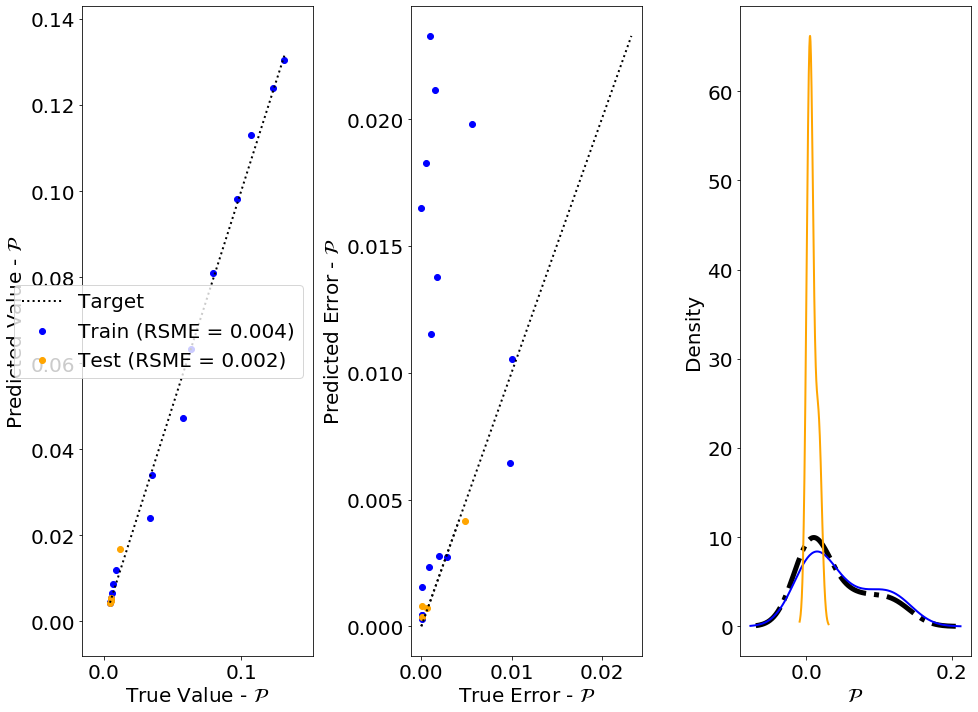

In [21]:
gp.test_train_plot()

In [16]:
X_star = np.geomspace(4e14, 4e15, 100)[:,None]
Y_star, V_epi, V_noise = gp.GP_predict(X_star, get_var=True)

In [17]:
X = np.exp(gp.get_input())
Y = np.exp(gp.get_output())

X_all = np.exp(read_json_file('Training_data/all_inputs.json'))
Y_all = np.exp(read_json_file('Training_data/all_outputs.json'))


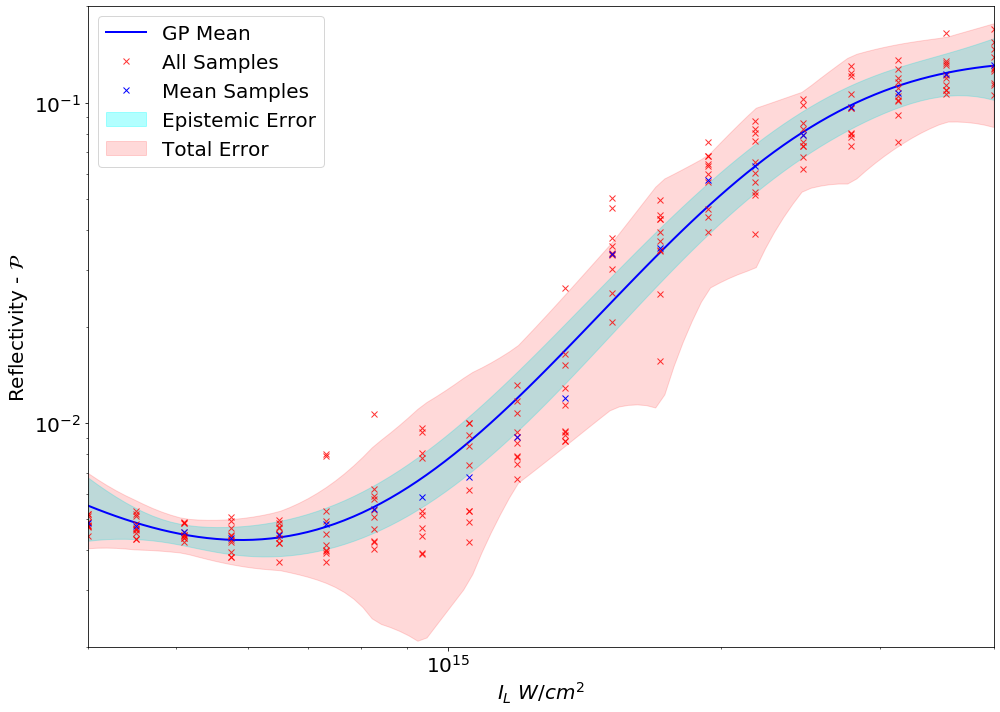

In [18]:
plt.rcParams["figure.figsize"] = [14, 10]

error_epi = 2.0*np.sqrt(V_epi)
error_tot = 2.0*np.sqrt(V_epi + V_noise)

Y_s = Y_star.flatten()
X_s = X_star.flatten()

plt.loglog(X_s, Y_s, color = 'blue', label = 'GP Mean')
plt.fill_between(X_s, (Y_s-error_epi), (Y_s+error_epi), alpha = 0.3, color = 'cyan', label = 'Epistemic Error')
plt.fill_between(X_s, (Y_s-error_tot), (Y_s+error_tot), alpha = 0.15, color = 'red', label = 'Total Error')
plt.plot(X_all, Y_all, 'kx', color = 'red', label = 'All Samples', alpha = 0.8)
plt.plot(X, Y, 'kx', color = 'blue', label = 'Mean Samples')
plt.xlim(4e14, 4e15)
plt.ylim(2e-3, 2e-1)

plt.ylabel(r'Reflectivity - $\mathcal{P}$')
plt.xlabel(r'$I_{L} \,\, W/cm^{2}$')
plt.legend(loc = 0)

In [19]:
Y_star, V_epi, V_noise = gp.GP_predict(X_star = np.array([intensity])[:,None], get_var=True)
error_epi = 2.0*np.sqrt(V_epi)
error_noise = 2.0*np.sqrt(V_noise)
error_tot = 2.0*np.sqrt(V_epi + V_noise)

Text(0, 0.5, 'Error')

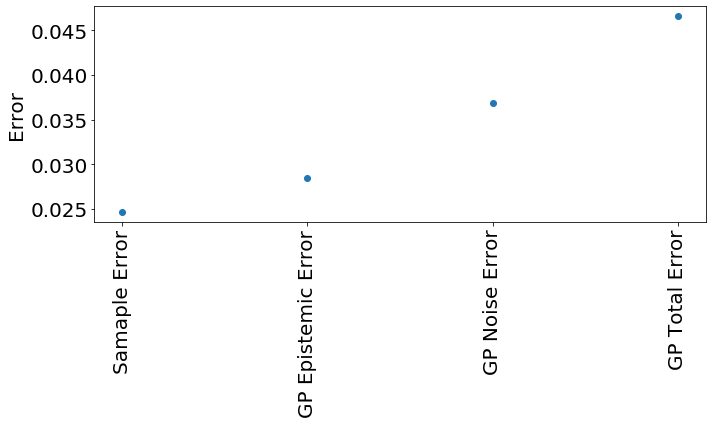

In [20]:
err_compare = [P_err, error_epi, error_noise, error_tot]
# plot scaled sensitivities
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(['Samaple Error', 'GP Epistemic Error', 'GP Noise Error', 'GP Total Error'], err_compare, 'o')
ax.set_xticklabels(['Samaple Error', 'GP Epistemic Error', 'GP Noise Error', 'GP Total Error'], rotation=90)
ax.set_ylabel(r'Error')